In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qucat import GUI
from scipy.constants import pi,hbar, h, e

# Understanding a tuneable coupler circuit

Here, we study the circuit of https://arxiv.org/abs/1802.10037 where two transmon qubits are coupled through a tuneable coupler.

This tuneable coupler is built from a capacitor and a Superconducting Quantum Interference Device, or SQUID.
By flux biasing the SQUID, we change the effective Josephson energy of the coupler, which modifies the coupling between the two transmons.
We will present how the normal mode visualization tool helps in understanding the physics of the device.
Secondly, we will show how a Hamiltonian generated with QuCAT accurately reproduces experimental measurements of the device.

We start by building the device shown below

![](graphics/TC_circuit.png)

*optical micrograph from https://arxiv.org/abs/1802.10037*

More specifically, we are interested in the part of the device in the dashed box, consisting of the two transmons and the tuneable coupler.
The other circuitry, the flux line, drive line and readout resonator could be included to determine external losses, or the dispersive coupling of the transmons to their readout resonator.
We will omit these features for simplicity here.

The circuit is built with the GUI

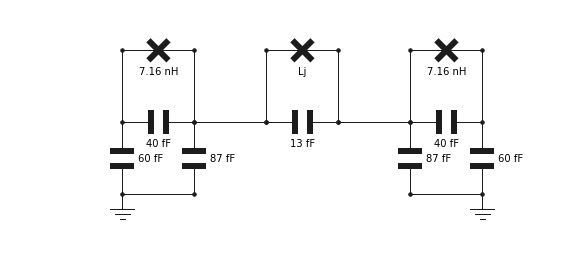

In [2]:
TC = GUI('circuits/tuneable_coupler.txt', # location of the circuit file
        edit=True, # open the GUI to edit the circuit
        plot=True, # plot the circuit after having edited it
        print_network=False) # print the network

The inductance $L_j$ of the junction which models the SQUID is given symbolically, and will have to be specified when calling future functions.
Since $L_j$ is controlled through flux $\phi$ in the experiment, we define a function which translates $\phi$ (in units of the flux quantum) to $L_j$

In [3]:
def Lj(phi):
    # maximum Josephson energy
    Ejmax = 6.5e9
    # junction asymmetry
    d = 0.0769
    # flux to Josephson energy
    Ej = Ejmax*np.cos(pi*phi) *np.sqrt(1+d**2 *np.tan(pi*phi)**2)
    # Josephson energy to inductance
    return (hbar/2/e)**2/(Ej*h)

To get an initial idea of the different modes of the circuit, let us display their resonance frequencies, their dissipation rates, anharmonicities and Kerr coefficients at 0 flux

In [7]:
f,k,A,chi = TC.f_k_A_chi(pretty_print=True, Lj=Lj(0))

         mode |       freq.  |       diss.  |       anha.  |
            0 |     3.27 GHz |          0Hz |      165 MHz |
            1 |     6.84 GHz |          0Hz |      128 MHz |
            2 |     6.98 GHz |          0Hz |      117 MHz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |         2    |
            0 |      165 MHz |              |              |
            1 |       13 MHz |      128 MHz |              |
            2 |     94.8 MHz |      234 MHz |      117 MHz |



By visualizing the normal modes of the circuit, we can understand the mechanism behind the tuneable coupler.
We plot the highest frequency mode at $\phi=0$

C:\Anaconda3\lib\site-packages\qucat\core.py:2499: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(hbar/np.real(z)/np.imag(dY(z,**kwargs)))


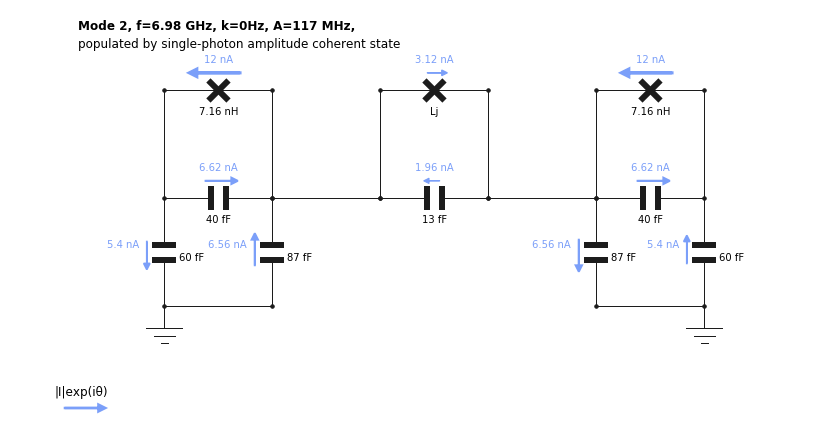

In [4]:
TC.show_normal_mode(mode = 2, 
    quantity = 'current',
    Lj=Lj(0))

This mode is called symmetric since the currents flow in the same direction on each side of the coupler.
This leads to a net current through the coupler junction, such that the value of $L_j$ influences the oscillation frequency of the mode.
Conversely, if we plot the anti-symmetric mode instead

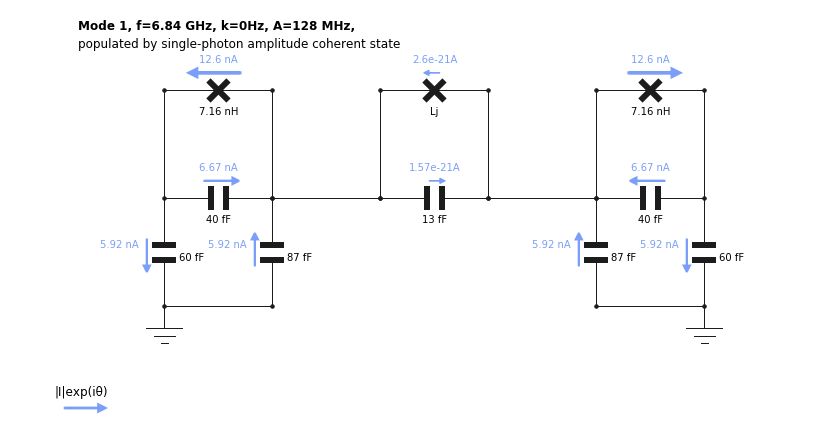

In [5]:
TC.show_normal_mode(mode = 1, 
    quantity = 'current',
    Lj=Lj(0))

currents are flowing away from the coupler in each transmon, we find a current through the coupler junction and capacitor on the order of $10^{-21}$ A.
This mode frequency should not vary as a function of $L_j$.
When the bare frequency of the coupler matches the coupled transmon frequencies, the coupler acts as a band-stop filter, and lets no current traverse.
At this point, both symmetric and anti-symmetric modes should have identical frequencies.

This effect is shown experimentally in Fig. 2(e) of https://arxiv.org/abs/1802.10037.

We can reproduce this experiment by generating a Hamiltonian with QuCAT and diagonalizing it with QuTiP for different values of the flux.

In [6]:
# modes to include when generating the system Hamiltonian
modes_to_include = [1,2]

# Values of the bias flux to sweep
phi_list = np.linspace(-0.25,0.5,201)

# Iitialize a list of transition frequencies
fs = [np.zeros(len(phi_list)) for mode in modes_to_include]

for i,phi in enumerate(phi_list):
    # Generate the Hamiltonian
    H = TC.hamiltonian(
        Lj = Lj(phi), 
        excitations = 7, 
        taylor = 4, 
        modes = modes_to_include)
    
    # compute eigenenergies and eigenstates
    ee,es = H.eigenstates()
    
    # Add the first two transition frequencies of the 
    # two modes considered to the list of transition frequencies
    for m,mode in enumerate(modes_to_include):
        fs[m][i] = ee[m+1]-ee[0]

Text(0, 0.5, 'Transition frequencies (GHz))')

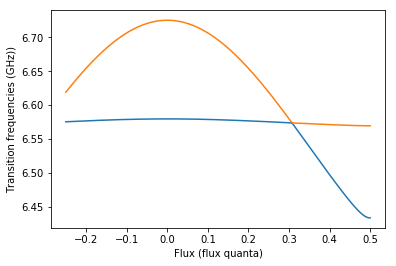

In [7]:
# Plot the eigenfrequencies
plt.plot(phi_list,fs[0]/1e9)
plt.plot(phi_list,fs[1]/1e9)
plt.xlabel('Flux (flux quanta)')
plt.ylabel('Transition frequencies (GHz))')

Note that we have constructed a Hamiltonian with modes 1 and 2, excluding mode 0, which corresponds to oscillations of current majoritarily located in the tuneable coupler.
One can verify this fact by plotting the distribution of currents for mode 0 using the `show_normal_mode` method.

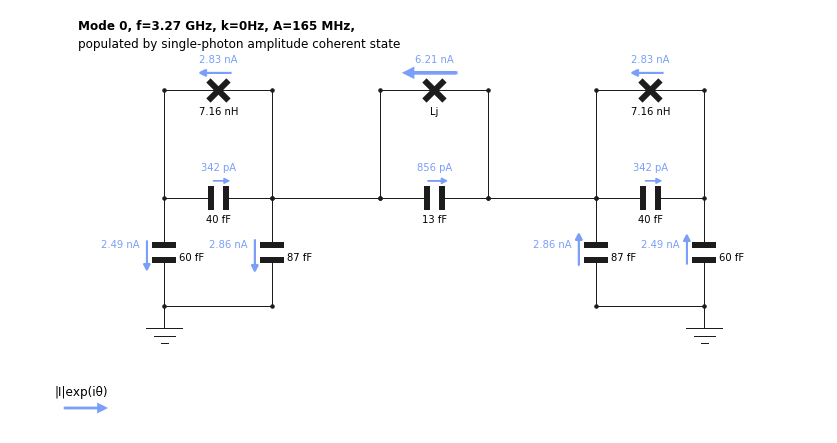

In [8]:
TC.show_normal_mode(mode = 0, 
    quantity = 'current',
    Lj=Lj(0))

This experiment can be viewed as two "bare" transmon qubits coupled by the interaction

$\hat H_\text{int} = g\sigma_x^L\sigma_x^R$

where left and right transmons are labeled $L$ and $R$ and $\sigma_x$ is the $x$ Pauli operator.
The coupling strength $g$ reflects the rate at which the two transmons can exchange quanta of energy.
If the transmons are resonant a spectroscopy experiment reveals a hybridization of the two qubits, which manifests as two spectroscopic absorption peaks separated in frequency by $2g$.
From this point of view, this experiment thus implements a coupling which is tuneable from an appreciable value to near 0 coupling.